In [3]:
import pandas as pd
import numpy as np
import pycaret.classification as pycc
import pylab as plt

## Indicators

In [ ]:
df = pd.read_csv("../data/qf2103_data.csv")
pivot_df = df.pivot_table(index=df['Date'], columns='ticker')
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.sort_values(by = 'Date')
for stock in ['AAPL', 'AMZN', 'GS', 'INTC', 'MSFT']:
    col_name = f'Adj Close_{stock}'
    
    window_short = 12
    window_long = 26
    pivot_df[f'SMA_{stock}_{window_short}'] = pivot_df[col_name].rolling(window=window_short).mean()
    pivot_df[f'SMA_{stock}_{window_long}'] = pivot_df[col_name].rolling(window=window_long).mean()
    pivot_df[f'EMA_{stock}_{window_short}'] = pivot_df[col_name].ewm(span=window_short, adjust=False).mean()
    pivot_df[f'EMA_{stock}_{window_long}'] = pivot_df[col_name].ewm(span=window_long, adjust=False).mean()

    pivot_df[f'MACD_{stock}'] = pivot_df[f'EMA_{stock}_{window_short}'] - pivot_df[f'EMA_{stock}_{window_long}']

    period = 14
    pivot_df[f'Lowest_{stock}'] = pivot_df[col_name].rolling(window=period).min()
    pivot_df[f'Highest_{stock}'] = pivot_df[col_name].rolling(window=period).max()
    pivot_df[f'Stoch_{stock}'] = ((pivot_df[col_name] - pivot_df[f'Lowest_{stock}']) / (pivot_df[f'Highest_{stock}'] - pivot_df[f'Lowest_{stock}'])) * 100
    high_low = pivot_df[f'Highest_{stock}'] - pivot_df[f'Lowest_{stock}']
    high_close_prev = np.abs(pivot_df[f'Highest_{stock}'] - pivot_df[col_name].shift(1))
    low_close_prev = np.abs(pivot_df[f'Lowest_{stock}'] - pivot_df[col_name].shift(1))
    true_range = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    pivot_df[f'ATR_{stock}'] = true_range.rolling(window=period).mean()
    pivot_df[f'OBV_{stock}'] = np.where(pivot_df[col_name].diff() > 0, pivot_df[f'Volume_{stock}'], 
                                        np.where(pivot_df[col_name].diff() < 0, -pivot_df[f'Volume_{stock}'], 0)).cumsum()

## For aapl CLASSIFICATION

In [168]:
stock = 'AAPL'
col_name = f'Adj Close_{stock}'
pivot_df[f'{stock}_next_day_direction'] = np.where(pivot_df[col_name] - pivot_df[col_name].shift(-1) > 0, 0, 1)
pivot_df = pivot_df.dropna()
pivot_df = pivot_df.sort_values(by = 'Date')
split_index = int(0.8 * len(pivot_df))
train_df = pivot_df.iloc[:split_index]
test_df = pivot_df.iloc[split_index:]
aapl_df = train_df


In [169]:
summary_preprocess = pycc.setup(aapl_df, target = 'AAPL_next_day_direction', session_id = 123)
x = pycc.get_config('X')
y = pycc.get_config('y')
trainX = pycc.get_config('X_train')
testX = pycc.get_config('X_test')
trainY = pycc.get_config('y_train')
testY = pycc.get_config('y_test')

,Description,Value
0,Session id,123
1,Target,AAPL_next_day_direction
2,Target type,Binary
3,Original data shape,"(1688, 82)"
4,Transformed data shape,"(1688, 82)"
5,Transformed train set shape,"(1181, 82)"
6,Transformed test set shape,"(507, 82)"
7,Numeric features,80
8,Categorical features,1
9,Preprocess,True


In [170]:
available_models = pycc.models()
available_models
best_clf = pycc.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5656,0.5668,0.6053,0.5856,0.5912,0.1275,0.1294,0.1330
ridge,Ridge Classifier,0.5385,0.0000,0.8251,0.5387,0.6515,0.0504,0.0613,0.1110
lr,Logistic Regression,0.5318,0.5220,0.6085,0.5474,0.5756,0.0566,0.0573,0.1880
knn,K Neighbors Classifier,0.5258,0.5223,0.5487,0.5461,0.5465,0.0496,0.0499,0.1450
nb,Naive Bayes,0.5258,0.5442,0.8820,0.5284,0.6598,0.0179,0.0244,0.0850
dt,Decision Tree Classifier,0.5233,0.5000,1.0000,0.5233,0.6870,0.0000,0.0000,0.0990
ada,Ada Boost Classifier,0.5233,0.5000,1.0000,0.5233,0.6870,0.0000,0.0000,0.0770
rf,Random Forest Classifier,0.5233,0.5821,1.0000,0.5233,0.6870,0.0000,0.0000,0.2580
gbc,Gradient Boosting Classifier,0.5233,0.5000,1.0000,0.5233,0.6870,0.0000,0.0000,0.4260
lda,Linear Discriminant Analysis,0.5233,0.5000,1.0000,0.5233,0.6870,0.0000,0.0000,0.0490


In [171]:
et_clf = pycc.create_model('et', fold = 5)
et_clf_custom_param = pycc.create_model('et', 
                                        max_depth = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5949,0.6261,0.7419,0.5897,0.6571,0.1778,0.1849
1,0.5085,0.5123,0.4274,0.5408,0.4775,0.0253,0.0260
2,0.5847,0.5796,0.5645,0.6140,0.5882,0.1709,0.1715
3,0.5297,0.5749,0.6829,0.5385,0.6022,0.0463,0.0483
4,0.5551,0.5985,0.6504,0.5634,0.6038,0.1024,0.1038
Mean,0.5546,0.5783,0.6134,0.5693,0.5858,0.1046,0.1069
Std,0.0325,0.0376,0.1093,0.0290,0.0590,0.0624,0.0636


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6050,0.6231,0.7258,0.6000,0.6569,0.2013,0.2064
1,0.5932,0.6028,0.6774,0.6000,0.6364,0.1787,0.1804
2,0.5085,0.4628,0.7742,0.5217,0.6234,-0.0118,-0.0139
3,0.5424,0.5688,0.6290,0.5571,0.5909,0.0760,0.0767
4,0.5169,0.5389,0.5968,0.5362,0.5649,0.0255,0.0257
5,0.5678,0.6417,0.3710,0.6571,0.4742,0.1531,0.1713
6,0.5254,0.4971,0.5323,0.5500,0.5410,0.0500,0.0501
7,0.4746,0.4960,0.5806,0.5000,0.5373,-0.0628,-0.0637
8,0.5847,0.6126,0.7049,0.5811,0.6370,0.1623,0.1664


In [172]:
et_clf_tuned = pycc.tune_model(et_clf, n_iter = 50)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:45:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5966,0.6321,0.5968,0.6167,0.6066,0.1930,0.1931
1,0.5932,0.6066,0.5806,0.6207,0.6000,0.1871,0.1876
2,0.5085,0.4568,0.5968,0.5286,0.5606,0.0075,0.0076
3,0.5424,0.5714,0.5806,0.5625,0.5714,0.0808,0.0808
4,0.5763,0.5559,0.6290,0.5909,0.6094,0.1474,0.1477
5,0.6186,0.6149,0.6129,0.6441,0.6281,0.2373,0.2376
6,0.5508,0.5328,0.6290,0.5652,0.5954,0.0939,0.0946
7,0.5254,0.5216,0.5484,0.5484,0.5484,0.0484,0.0484
8,0.5678,0.5827,0.6066,0.5781,0.5920,0.1331,0.1333


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [158]:
et_clf_bagged = pycc.ensemble_model(et_clf, 
                                    method = 'Bagging', 
                                    fold = 5,
                                    n_estimators = 50)

In [174]:
et_clf_boosted = pycc.ensemble_model(et_clf, 
                                     method = 'Boosting', 
                                     fold = 5,
                                     n_estimators = 50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5527,0.6204,0.6048,0.5682,0.5859,0.1007,0.1010
1,0.4915,0.5107,0.5242,0.5159,0.5200,-0.0205,-0.0205
2,0.5975,0.5952,0.5887,0.6239,0.6058,0.1953,0.1956
3,0.5763,0.5794,0.5203,0.6095,0.5614,0.1565,0.1583
4,0.5424,0.5402,0.3415,0.6087,0.4375,0.1006,0.1126
Mean,0.5521,0.5692,0.5159,0.5852,0.5421,0.1065,0.1094
Std,0.0358,0.0391,0.0935,0.0393,0.0596,0.0729,0.0732


In [177]:
pred_unseen = pycc.predict_model(et_clf_boosted,
                                raw_score = True,
                                data = test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.4563,0.4923,0.0619,0.4375,0.1085,-0.0277,-0.0555


## For Regression with Thresholding

In [179]:
stock = 'AAPL'
col_name = f'Adj Close_{stock}'
pivot_df[f'{stock}_price'] = pivot_df[col_name].shift(-1)
pivot_df = pivot_df.dropna()
pivot_df = pivot_df.sort_values(by = 'Date')
split_index = int(0.8 * len(pivot_df))
train_df = pivot_df.iloc[:split_index]
test_df = pivot_df.iloc[split_index:]
aapl_df = train_df

In [180]:
pivot_df

,Date,Adj Close_AAPL,Adj Close_AMZN,Adj Close_GS,Adj Close_INTC,Adj Close_MSFT,Close_AAPL,Close_AMZN,Close_GS,Close_INTC,...,SMA_MSFT_26,EMA_MSFT_12,EMA_MSFT_26,MACD_MSFT,Lowest_MSFT,Highest_MSFT,Stoch_MSFT,ATR_MSFT,OBV_MSFT,AAPL_price
26,2010-02-10,5.899589,5.868000,120.340714,12.984957,21.190636,6.968571,5.868000,153.630005,19.690001,...,22.331495,21.556958,22.101423,-0.544465,20.986223,22.462523,13.846275,1.947314,-245451700.0,6.006926
27,2010-02-11,6.006926,6.004500,120.669701,13.228961,21.289059,7.095357,6.004500,154.050003,20.059999,...,22.248798,21.515743,22.041248,-0.525505,20.986223,22.462523,20.513148,1.937039,-179458000.0,6.058629
28,2010-02-12,6.058629,5.983000,120.575676,13.472966,21.145216,7.156429,5.983000,153.929993,20.430000,...,22.166102,21.458739,21.974875,-0.516137,20.986223,22.462523,10.769684,1.926764,-260575200.0,6.149940
29,2010-02-16,6.149940,5.876500,123.293724,13.664207,21.563551,7.264286,5.876500,157.399994,20.719999,...,22.108814,21.474864,21.944407,-0.469543,20.986223,22.462523,39.106415,1.916489,-208639600.0,6.124242
30,2010-02-17,6.124242,5.815500,123.184135,13.624635,21.746098,7.233929,5.815500,157.259995,20.660000,...,22.052432,21.516592,21.929717,-0.413125,20.986223,22.076422,69.700548,1.878635,-162756700.0,6.135729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131,2018-06-21,44.135593,86.511002,198.661438,44.827896,95.086685,46.365002,86.511002,226.979996,52.189999,...,93.836295,94.864060,93.794121,1.069939,94.137138,96.355896,42.796329,4.288423,-558334300.0,44.007080
2132,2018-06-22,44.007080,85.783501,197.821228,45.094154,94.400383,46.230000,85.783501,226.020004,52.500000,...,93.954175,94.792725,93.839029,0.953695,94.137138,96.355896,11.864506,4.078233,-597257400.0,43.352642
2133,2018-06-25,43.352642,83.157501,193.900131,43.556660,92.501305,45.542500,83.157501,221.539993,50.709999,...,94.034088,94.440199,93.739939,0.700260,92.501305,96.355896,0.000000,3.949970,-632690700.0,43.890469
2134,2018-06-26,43.890469,84.554497,193.935135,42.663368,93.149979,46.107498,84.554497,221.580002,49.669998,...,94.132442,94.241703,93.696238,0.545465,92.501305,95.773003,19.826830,3.759924,-605793500.0,43.826221


In [182]:
from pycaret.regression import *
regExp = setup(aapl_df, target = 'AAPL_price', session_id = 123)

,Description,Value
0,Session id,123
1,Target,AAPL_price
2,Target type,Regression
3,Original data shape,"(1688, 82)"
4,Transformed data shape,"(1688, 82)"
5,Transformed train set shape,"(1181, 82)"
6,Transformed test set shape,"(507, 82)"
7,Numeric features,80
8,Categorical features,1
9,Preprocess,True


In [183]:
available_models_regreesion = regExp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.3444,0.1867,0.4316,0.9955,0.0295,0.0235,0.1110
knn,K Neighbors Regressor,0.3868,0.3239,0.5665,0.9922,0.0340,0.0243,0.0700
lasso,Lasso Regression,0.4641,0.3266,0.5709,0.9921,0.0435,0.0333,0.0640
llar,Lasso Least Angle Regression,0.4694,0.3340,0.5773,0.9920,0.0439,0.0337,0.0710
et,Extra Trees Regressor,1.7082,3.7671,1.9387,0.9098,0.1168,0.1127,0.9010
omp,Orthogonal Matching Pursuit,1.7609,4.5315,2.1266,0.8910,0.2019,0.1291,0.0630
huber,Huber Regressor,1.7264,4.9784,2.2252,0.8804,0.3186,0.1356,0.0940
ridge,Ridge Regression,3.3536,15.3390,3.9120,0.6331,0.2473,0.2411,0.1040
par,Passive Aggressive Regressor,3.4222,19.8026,4.1301,0.5194,0.2544,0.2188,0.0500
lightgbm,Light Gradient Boosting Machine,5.4075,39.9673,6.3140,0.0443,0.3754,0.3866,1.2790


In [204]:
lasso_reg = regExp.create_model('lasso', fold =10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4195,0.2796,0.5287,0.9926,0.0363,0.0280
1,0.4680,0.3398,0.5829,0.9906,0.0467,0.0349
2,0.4604,0.3081,0.5551,0.9932,0.0456,0.0348
3,0.4988,0.3549,0.5958,0.9917,0.0514,0.0387
4,0.4643,0.3130,0.5595,0.9929,0.0409,0.0328
5,0.4673,0.3243,0.5695,0.9928,0.0437,0.0339
6,0.4653,0.3435,0.5861,0.9922,0.0394,0.0305
7,0.4357,0.2915,0.5399,0.9920,0.0371,0.0298
8,0.4668,0.3304,0.5748,0.9913,0.0416,0.0326


In [205]:
lasso_reg_tuned = regExp.tune_model(lasso_reg, n_iter = 50)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [206]:
pred_unseen = pycc.predict_model(lasso_reg_tuned,
                                raw_score = True,
                                data = test_df)

In [207]:
pred_unseen

,Date,Adj Close_AAPL,Adj Close_AMZN,Adj Close_GS,Adj Close_INTC,Adj Close_MSFT,Close_AAPL,Close_AMZN,Close_GS,Close_INTC,...,EMA_MSFT_12,EMA_MSFT_26,MACD_MSFT,Lowest_MSFT,Highest_MSFT,Stoch_MSFT,ATR_MSFT,OBV_MSFT,AAPL_price,prediction_label
1714,2016-10-24,27.198177,41.904499,149.944473,28.867510,55.220249,29.412500,41.904499,175.119995,35.259998,...,52.733768,52.324921,0.408847,51.526829,55.220249,100.000000,1.334595,-1.354707e+09,27.336880,27
1715,2016-10-25,27.336880,41.758999,150.312698,28.736525,55.211212,29.562500,41.758999,175.550003,35.099998,...,53.114914,52.538723,0.576193,51.526829,55.220249,99.755318,1.519525,-1.389844e+09,26.721945,27
1716,2016-10-26,26.721945,41.129501,151.614182,28.589161,54.885303,28.897499,41.129501,177.070007,34.919998,...,53.387283,52.712543,0.674739,51.526829,55.220249,90.931290,1.704455,-1.419755e+09,26.465332,26
1717,2016-10-27,26.465332,40.917999,152.196365,28.499104,54.405525,28.620001,40.917999,177.750000,34.810001,...,53.543934,52.837948,0.705986,51.526829,55.220249,77.941208,1.889385,-1.448235e+09,26.289639,26
1718,2016-10-28,26.289639,38.816002,151.674118,28.441793,54.197323,28.430000,38.816002,177.139999,34.740002,...,53.644455,52.938644,0.705813,51.526829,55.220249,72.304092,2.079488,-1.481810e+09,26.248035,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131,2018-06-21,44.135593,86.511002,198.661438,44.827896,95.086685,46.365002,86.511002,226.979996,52.189999,...,94.864059,93.794121,1.069939,94.137138,96.355896,42.796329,4.288423,-5.583343e+08,44.007080,43
2132,2018-06-22,44.007080,85.783501,197.821228,45.094154,94.400383,46.230000,85.783501,226.020004,52.500000,...,94.792725,93.839027,0.953695,94.137138,96.355896,11.864506,4.078233,-5.972574e+08,43.352642,43
2133,2018-06-25,43.352642,83.157501,193.900131,43.556660,92.501305,45.542500,83.157501,221.539993,50.709999,...,94.440201,93.739937,0.700260,92.501305,96.355896,0.000000,3.949970,-6.326907e+08,43.890469,43
2134,2018-06-26,43.890469,84.554497,193.935135,42.663368,93.149979,46.107498,84.554497,221.580002,49.669998,...,94.241707,93.696236,0.545465,92.501305,95.773003,19.826830,3.759924,-6.057935e+08,43.826221,43


## Test

In [39]:
df = pd.read_csv("../data/qf2103_data.csv", index_col="Date", parse_dates= True)

In [40]:
df_aapl = df[df['ticker'] == 'AAPL']

In [43]:
df_aapl['log returns'] = np.log(df_aapl['Adj Close'] / df_aapl['Adj Close'].shift(1))
df_aapl = df_aapl.dropna()

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

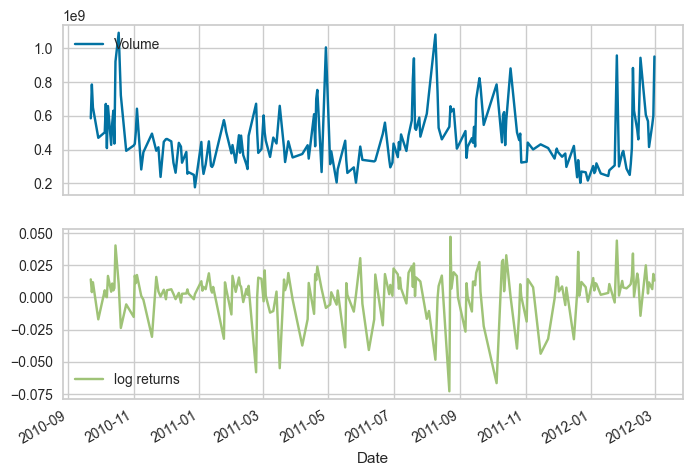

In [44]:
df_aapl[['Volume', 'log returns']].iloc[100:300].plot(subplots=True)

In [51]:
np.corrcoef(df_aapl['Open'], df_aapl['Volume'])

array([[ 1.       , -0.6645375],
       [-0.6645375,  1.       ]])

In [46]:
df_aapl

,ticker,Open,High,Low,Close,Adj Close,Volume,log returns
Date,,,,,,,,
2010-01-08,AAPL,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,-0.011258
2010-01-13,AAPL,7.423929,7.533214,7.289286,7.523214,6.369149,605892000,-0.006294
2010-01-19,AAPL,7.440357,7.685357,7.401429,7.680000,6.501883,730007600,0.020626
2010-01-25,AAPL,7.232500,7.310714,7.149643,7.252500,6.139962,1065699600,-0.057273
2010-01-26,AAPL,7.355357,7.632500,7.235000,7.355000,6.226740,1867110000,0.014034
...,...,...,...,...,...,...,...,...
2018-06-12,AAPL,47.847500,48.152500,47.787498,48.070000,45.758614,67644400,-0.008802
2018-06-14,AAPL,47.887501,47.892502,47.555000,47.700001,45.406403,86440400,-0.007727
2018-06-20,AAPL,46.587502,46.799999,46.432499,46.625000,44.383087,82514800,-0.022795
